In [157]:
import numpy as np
from numpy import exp, pi
S_c = [([0,1,0], 1), ([0,1,1], 0), ([1,0,1], 0), ([1,1,1], 0)]
T_c = [([1,0,0], 1), ([0,0,1], 1), ([1,0,1], 0), ([0,0,0], 0)]

from qiskit import QuantumCircuit
num_qubits = 3
def encode(data) -> QuantumCircuit:
    num_qubits = len(data)
    qc = QuantumCircuit(num_qubits)
    for k,i in enumerate(data): 
        if i == 1: qc.x(k)
    return qc

S = [(encode(s[0]), s[1]) for s in S_c]
T = [(encode(t[0]), t[1]) for t in T_c]

In [158]:
from qiskit.circuit import QuantumCircuit, ParameterVector
ansatz = QuantumCircuit(3)
def univ_2bits(ansatz: QuantumCircuit, parameters, ind):
    ansatz.u(parameters[0], parameters[1], parameters[2], ind)
    ansatz.cry(parameters[3], ind, (ind+1) % ansatz.num_qubits)
    ansatz.u(parameters[6], parameters[7], parameters[8], ind)

theta = ParameterVector('θ', 27)
# univ_2bits(ansatz, theta[0:6], 0)
univ_2bits(ansatz, theta[0:9], 0)
ansatz.barrier()
# univ_2bits(ansatz, theta[6:12], 1)
univ_2bits(ansatz, theta[9:18], 1)
ansatz.barrier()
# univ_2bits(ansatz, theta[12:18], 2)
univ_2bits(ansatz, theta[18:27], 2)
ansatz.draw()

┌───────────────────┐            ┌───────────────────┐ ░ »
q_0: ┤ U(θ[0],θ[1],θ[2]) ├─────■──────┤ U(θ[6],θ[7],θ[8]) ├─░─»
     └───────────────────┘┌────┴─────┐└───────────────────┘ ░ »
q_1: ─────────────────────┤ Ry(θ[3]) ├──────────────────────░─»
                          └──────────┘                      ░ »
q_2: ───────────────────────────────────────────────────────░─»
                                                            ░ »
«                                                                  ░ »
«q_0: ─────────────────────────────────────────────────────────────░─»
«     ┌─────────────────────┐             ┌──────────────────────┐ ░ »
«q_1: ┤ U(θ[9],θ[10],θ[11]) ├──────■──────┤ U(θ[15],θ[16],θ[17]) ├─░─»
«     └─────────────────────┘┌─────┴─────┐└──────────────────────┘ ░ »
«q_2: ───────────────────────┤ Ry(θ[12]) ├─────────────────────────░─»
«                            └───────────┘                         ░ »
«                             ┌───────────┐                        
«q_0: ────────────────────────┤ Ry(θ[21]) ├────────────────────────
«                             └─────┬─────┘                        
«q_1: ──────────────────────────────┼──────────────────────────────
«     ┌──────────────────────┐      │      ┌──────────────────────┐
«q_2: ┤ U(θ[18],θ[19],θ[20]) ├──────■──────┤ U(θ[24],θ[25],θ[26]) ├
«     └──────────────────────┘             └──────────────────────┘

In [159]:
from qiskit.providers.aer import AerSimulator
from qiskit.utils import QuantumInstance
from qiskit.opflow import StateFn, PauliExpectation, CircuitSampler, Gradient, Z, I 
from qiskit import transpile
# Initialize Gradient calculator & Sampler
shifter = Gradient()
sampler = CircuitSampler(QuantumInstance(AerSimulator()))
ansatz = transpile(ansatz)
# ansatz = RealAmplitudes(num_qubits, reps=2, entanglement='circular')

observable = Z^I^I # + I^Z^I + I^I^Z

def eval_expct(ansatz:QuantumCircuit, theta):
    expectation = StateFn(observable, is_measurement=True) @ StateFn(ansatz)
    pauli_basis = PauliExpectation().convert(expectation)
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(pauli_basis, params=value_dict).eval()
    return np.real(result)


In [160]:
def logistic(x, k = 2):
    mother = 1 + exp(- k*x )
    return 1 / mother

def cost( para):
    loss = 0
    for qcirc, label in S:
        qc = qcirc.compose(ansatz)
        judgement = logistic(eval_expct(qc, para))
        loss += (judgement - label)**2
    return loss

In [161]:
def grad(func, para: np.array, EPS = 0.1) -> np.array:
    n = len(para)
    gradient = [0]*n
    for i in range(n):
        # calculate partial f_i
        e_i = np.identity(n)[:, i]
        plus = para + EPS*e_i
        minus = para - EPS*e_i
        gradient[i] = (func(plus) - func(minus)) / (2*EPS)
    return np.array(gradient)


from copy import copy

def grad_des(func, para, callback, maxiter = 100, eta = 0.5):
    theta = copy(para)
    for i in range(maxiter):
        callback(func(theta), theta)
        theta = theta - eta * grad(func, theta)

In [162]:
from My_qcirc import generate_freegroup, SWAP, tensor, Ry,Ad, trace, dagger
from qiskit.quantum_info.operators import Operator

H = generate_freegroup([SWAP(0,1,3), SWAP(1,2,3), SWAP(2,0,3)])

def Twirling(O: np.matrix, symmetry_group: list) -> np.matrix:
    SOS_list = [Ad(symmetry_op, O) for symmetry_op in symmetry_group ]
    return 1/6 * sum(O)

def g(para, observable, symmetry_group) -> float:
    value_dict = dict(zip(ansatz.parameters, para))
    U = np.matrix(Operator(ansatz.bind_parameters(value_dict)))
    O = Ad(U, np.matrix(Operator(observable)))
    PO = Twirling(O, symmetry_group)
    delta = O - PO
    return trace(delta @ dagger(delta)).real


In [163]:
init_para = np.random.random(ansatz.num_parameters) * 2*pi
maxiter = 15

func_list = []
x_list = []
def callback(y, x):
    func_list.append(y)
    x_list.append(x)

grad_des(cost, init_para, callback, maxiter = maxiter)


In [164]:
from functools import partial
gg = partial(g, observable = observable, symmetry_group = H)

lamd = 1
funcG_list = []
xG_list = []
def callback_g(y, x):
    funcG_list.append(y - lamd*gg(x))
    xG_list.append(x)
grad_des(lambda x: cost(x) + lamd * gg(x), 
        init_para, callback_g, maxiter = maxiter)

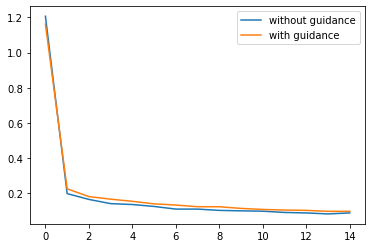

In [165]:
import matplotlib.pyplot as plt
plt.plot(func_list, label='without guidance')
plt.plot(funcG_list, label='with guidance')
plt.legend()

In [170]:
def test_err( para):
    loss = 0
    for qcirc, label in T:
        qc = qcirc.compose(ansatz)
        judgement = logistic(eval_expct(qc, para))
        loss += (judgement - label)**2
    return loss

err_1 = test_err(x_list[-1])
err_2 = test_err(xG_list[-1])

print("test error without symmetry error: %f" % err_1)
print("test error with symmetry error: %f" % err_2)
print("improvement rate: %f" % (err_1/err_2 -1))

test error without symmetry error: 1.513080
test error with symmetry error: 1.407832
improvement rate: 0.074759
